<a href="https://www.kaggle.com/code/datascrum/youtube-viewing-history-analysis?scriptVersionId=156192507" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview:
In this Analysis I wanted to review my viewing history of Youtube data I recently received.

Before I could begin, I had to get the data together. YouTube shares your viewing history as an HTML file and it includes all the ads that pop up too. To resolve this, I used BeautifulSoup to parse through the HTML file to get the video title, channel, and date/time, while skipping the ads - sadly the file doesn't include anymore interesting information than that.

## Notes:
There are a few limitations to the data I want to share:
- I have two YouTube accounts and up until a few years ago, the account we're reviewing here was only used to upload videos to my channel but not to actually engage in content so it's not an entirely clear picture of my content viewing habits.
- The data does not have duration of how long I watched the videos so we can't rule out videos that only played for a few seconds or videos that may be been left on for hours as background noise.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

---
# Prepare Data
In this section we'll prepare the data such as scraping the html file to create the csv and making sure it's in the correct structure I need.

## Example of BeautifulSoup Code to create CSV
This code below is just an example of what was used to create the CSV from the HTML file. 

    from bs4 import BeautifulSoup

    # Open the HTML file with explicit encoding (e.g., 'utf-8')
    with open("/kaggle/input/watch-history/watch-history.html", "r", encoding="utf-8") as html_file:
    contents = html_file.read()

    soup = BeautifulSoup(contents, "lxml")

    # Find all divs with the specified class
    content_cells = soup.find_all(
        "div", class_="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1"
    )

    # Initialize lists to store data
    video_titles = []
    channel_names = []
    date_times = []

    # Loop through each content cell and extract information
    for content_cell in content_cells:
        if "Watched at" in content_cell.text: # ignore ads
            continue 

        # Extract video title if <a> element exists
        a_elements = content_cell.find_all("a")
        video_title = a_elements[0].text.strip() if a_elements else None
        channel_name = a_elements[1].text.strip() if len(a_elements) > 1 else None

        # Extract date/time
        date_time_str = (
            content_cell.find_all("br")[1]
            .next_sibling.strip()
            .replace("EST", "")
            if len(content_cell.find_all("br")) >= 2
            else None
        )

        date_time = pd.to_datetime(date_time_str, errors="coerce")

        video_titles.append(video_title)
        channel_names.append(channel_name)
        date_times.append(date_time)

    # Create a DataFrame
    data = {
        "Video Title": video_titles,
        "Channel Name": channel_names,
        "Date/Time": date_times,
    }
    df = pd.DataFrame(data)
    df.to_csv('youtube_data'')

In [2]:
df = pd.read_csv('/kaggle/input/yt-history/youtube_view_history.csv', parse_dates=['Date/Time'], date_format='%m/%d/%Y %H:%M')

---
# Explore and Clean
Here we'll do a quick overview of the data structure and see if we need to make any additional adjustments before we can start analyizing it.

In [3]:
df.dtypes

Unnamed: 0               int64
Video Title             object
Channel Name            object
Date/Time       datetime64[ns]
dtype: object

In [4]:
# I forgot to remove the index when creating this CSV so let's drop that here.
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df.sample(10)

,Video Title,Channel Name,Date/Time
8702,#shorts,Trendylook,2022-04-10 10:30:00
16297,Some red curbs need a little more TLC than oth...,Sean Bolis Vlogs,2021-03-12 20:21:00
9724,Google Sheets - Inventory Management System Te...,Learn Google Sheets & Excel Spreadsheets,2022-04-01 05:26:00
6832,Why Trevor Lawrence's rookie season was WAY be...,Billy Stephens,2022-08-19 15:40:00
22206,The Last of Us Part 2 Walkthrough Part 1 - FIR...,TetraNinja,2020-06-18 17:56:00
5054,The Art of Strategy,Robert Greene,2023-01-04 13:21:00
2434,Stealing Expensive Cars as Fake Cop in GTA 5 RP..,LennyBarn,2023-08-01 05:23:00
18627,I Bought A Private Island,MrBeast,2021-01-05 14:57:00
10204,Multitool | Robinhood,NaN,NaT
23239,COCAINE DISCOVERED INSIDE EMMY AWARD,Marc Rebillet,2020-03-08 14:46:00


In [6]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

summary(df).style.background_gradient(cmap='Reds')
# This just creates a summary of the data, df.describe() does something similar

data shape: (25222, 3)


,data type,#missing,%missing,#unique,min,max,average,first value,second value,third value
Video Title,object,426,1.689002,23382,NaT,NaT,NaT,60 Seconds speedruns are incredibly dark,Todd McFarlane Answers Comics Questions From Twitter | Tech Support | WIRED,"How this ""terrible artist"" made MILLIONS"
Channel Name,object,2164,8.579811,8663,NaT,NaT,NaT,EazySpeezy,WIRED,matttt
Date/Time,datetime64[ns],2161,8.567917,19621,2017-03-17 09:32:00,2023-12-21 20:49:00,2021-09-30 12:45:10.251073536,2023-12-21 20:49:00,2023-12-21 20:48:00,2023-12-21 20:32:00


In [7]:
# Sometimes it looks like youtube provides the URL instead of the title and
# doesn't capture the channel, datetime; so we'll drop those
df = df.dropna(axis=0, how='any')
summary(df).style.background_gradient(cmap='Reds')

data shape: (23058, 3)


,data type,#missing,%missing,#unique,min,max,average,first value,second value,third value
Video Title,object,0,0.000000,21833,NaT,NaT,NaT,60 Seconds speedruns are incredibly dark,Todd McFarlane Answers Comics Questions From Twitter | Tech Support | WIRED,"How this ""terrible artist"" made MILLIONS"
Channel Name,object,0,0.000000,8663,NaT,NaT,NaT,EazySpeezy,WIRED,matttt
Date/Time,datetime64[ns],0,0.000000,19620,2017-03-17 09:32:00,2023-12-21 20:49:00,2021-09-30 11:36:06.599011072,2023-12-21 20:49:00,2023-12-21 20:48:00,2023-12-21 20:32:00


In [8]:
# Let's create a few new columns to answer a few more questions
df['Month'] = df['Date/Time'].dt.month
df['Hour_of_day'] = df['Date/Time'].dt.hour
df['Year'] = df['Date/Time'].dt.year
df['Dow'] = df['Date/Time'].dt.day_of_week
df['Hour_of_day'].unique() # making sure it's in 24 hr format

array([20, 15, 14, 10, 21, 18, 13, 12, 11,  7, 16, 19,  9,  6,  5, 17,  8,
        4, 22,  3,  2,  1, 23,  0], dtype=int32)

In [9]:
df.sample(5)

,Video Title,Channel Name,Date/Time,Month,Hour_of_day,Year,Dow
1496,i made every pasta shape to prove a point,Answer in Progress,2023-09-23 13:09:00,9,13,2023,5
8391,Family Guy - What was all that noise in your b...,Mr. Rupert,2022-04-16 07:13:00,4,7,2022,5
6925,How to Double Your Savings with Python,Patrick Loeber,2022-08-14 08:18:00,8,8,2022,6
5111,Become a Master Persuader,Robert Greene,2022-12-30 08:27:00,12,8,2022,4
8887,ELDEN RING: Strength Invasions!,ChaseTheBro,2022-04-09 16:44:00,4,16,2022,5


---
# Analysis
The data looks good now so we can proceed to move through the questions I've come up with about the data.


---
## Question: When does this data begin?

In [10]:
# March 03, 2017 - This is likely when I created this YouTube account
# but I didn't start watching content on it until later, which I'm sure we'll see.
df['Date/Time'].sort_values().head(1)

25221   2017-03-17 09:32:00
Name: Date/Time, dtype: datetime64[ns]

---
## Question: What Channel have I watched the most videos from?

In [11]:
# I used to play Fantasy Football for work; instead of watching NFL games
# I would watch the highlights and some news reports to help make decisions.
df.groupby('Channel Name').size().reset_index(name='count').sort_values(by='count').tail(10)

,Channel Name,count
2882,Highlight Heaven,89
5618,Raxxanterax,90
5213,Path of Exile,118
6256,South China Morning Post,120
1372,Coffeezilla,174
1601,Daily Stoic,228
2447,FrocketGaming,419
3005,IGN,420
4042,Linus Tech Tips,568
4777,NFL,729


---

## Question: What is my peak month for watching YouTube?

Text(0, 0.5, 'Amt of Videos Watched')

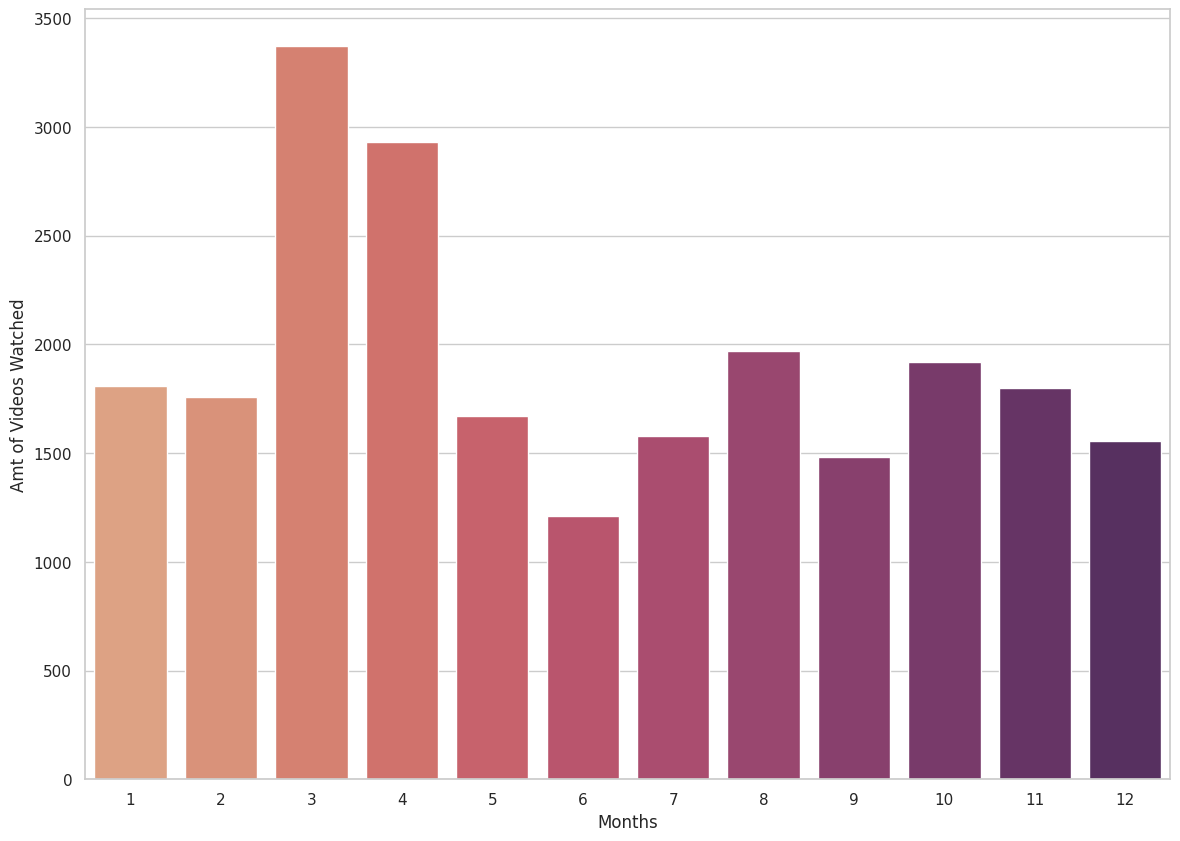

In [12]:
monthly_agg = df.groupby('Month').size().reset_index(name='count')

color = sns.color_palette('flare', n_colors=len(monthly_agg['Month'].unique()))

plt.figure(figsize=(14,10))
sns.barplot(x='Month', y='count', data=monthly_agg, palette=color)
plt.xlabel('Months')
plt.ylabel('Amt of Videos Watched')

---

## Question: What about months by year?

In [13]:
grouped_year_month = df.groupby(['Month', 'Year'])['Month'].value_counts().reset_index()
grouped_year_month

,Month,Year,count
0,1,2018,102
1,1,2019,10
2,1,2020,62
3,1,2021,944
4,1,2022,253
...,...,...,...
75,12,2019,27
76,12,2020,624
77,12,2021,204
78,12,2022,255


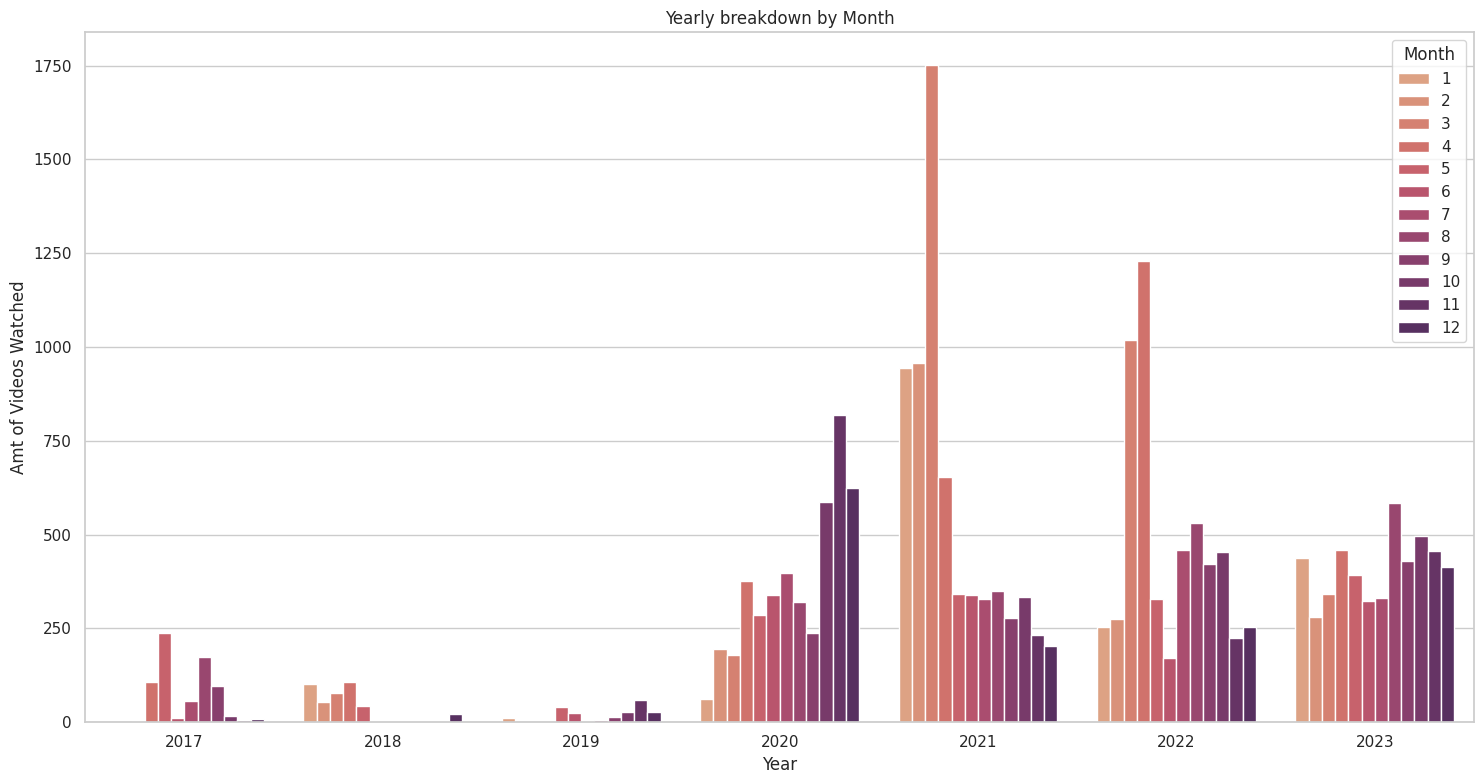

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))

custom_palette = sns.color_palette("flare", n_colors=len(grouped_year_month['Month'].unique()))

# Use seaborn's barplot to create a grouped bar chart
sns.barplot(x='Year', y='count', hue='Month', data=grouped_year_month, ax=ax, palette=custom_palette)

# Customize plot
ax.set_xlabel('Year')
ax.set_ylabel('Amt of Videos Watched')
ax.set_title('Yearly breakdown by Month')

ax.legend(title='Month', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

---

## Question: What channel was I watching the most of in March of 2021?

In [15]:
march_2021 = df[(df['Year'] == 2021) & (df['Month'] == 3)]
march_2021.groupby('Channel Name').size().reset_index(name='count').sort_values(by='count').tail(10)

# Was I looking for drama? lol

,Channel Name,count
502,LSToast,10
590,Moga,12
384,Insider Art,13
55,Answer in Progress,13
942,Top of Top,14
542,MC WORKOUT,16
526,Linus Tech Tips,22
375,IGN,26
165,Coffeezilla,32
816,South China Morning Post,48


---

## Question: What hours are the day am I most active?

Text(0, 0.5, 'Amt of Videos Watched')

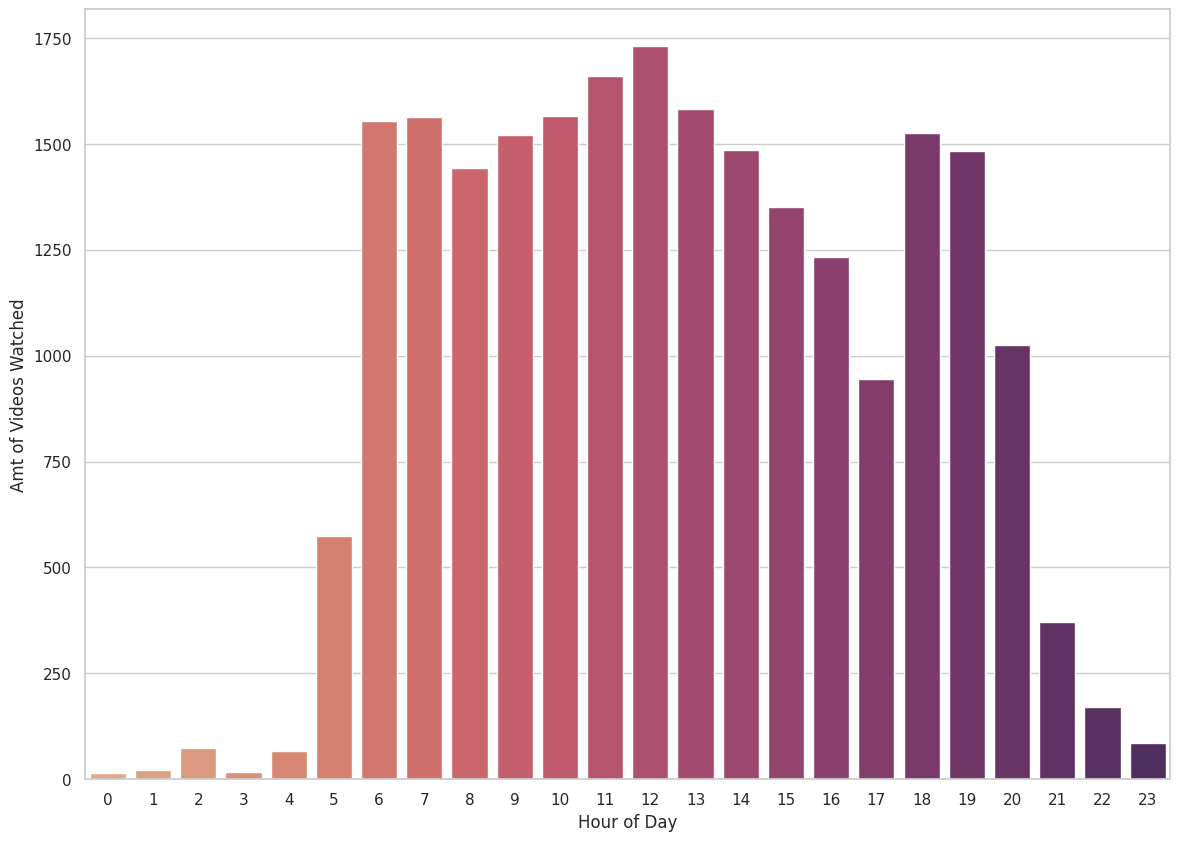

In [16]:
hourly_breakdown = df.groupby('Hour_of_day').size().reset_index(name='count')

color = sns.color_palette('flare', n_colors=len(hourly_breakdown['Hour_of_day'].unique()))

plt.figure(figsize=(14,10))
sns.barplot(x='Hour_of_day', y='count', data=hourly_breakdown, palette=color)
plt.xlabel('Hour of Day')
plt.ylabel('Amt of Videos Watched')

---

## Question: Let's go further and review by Month too.

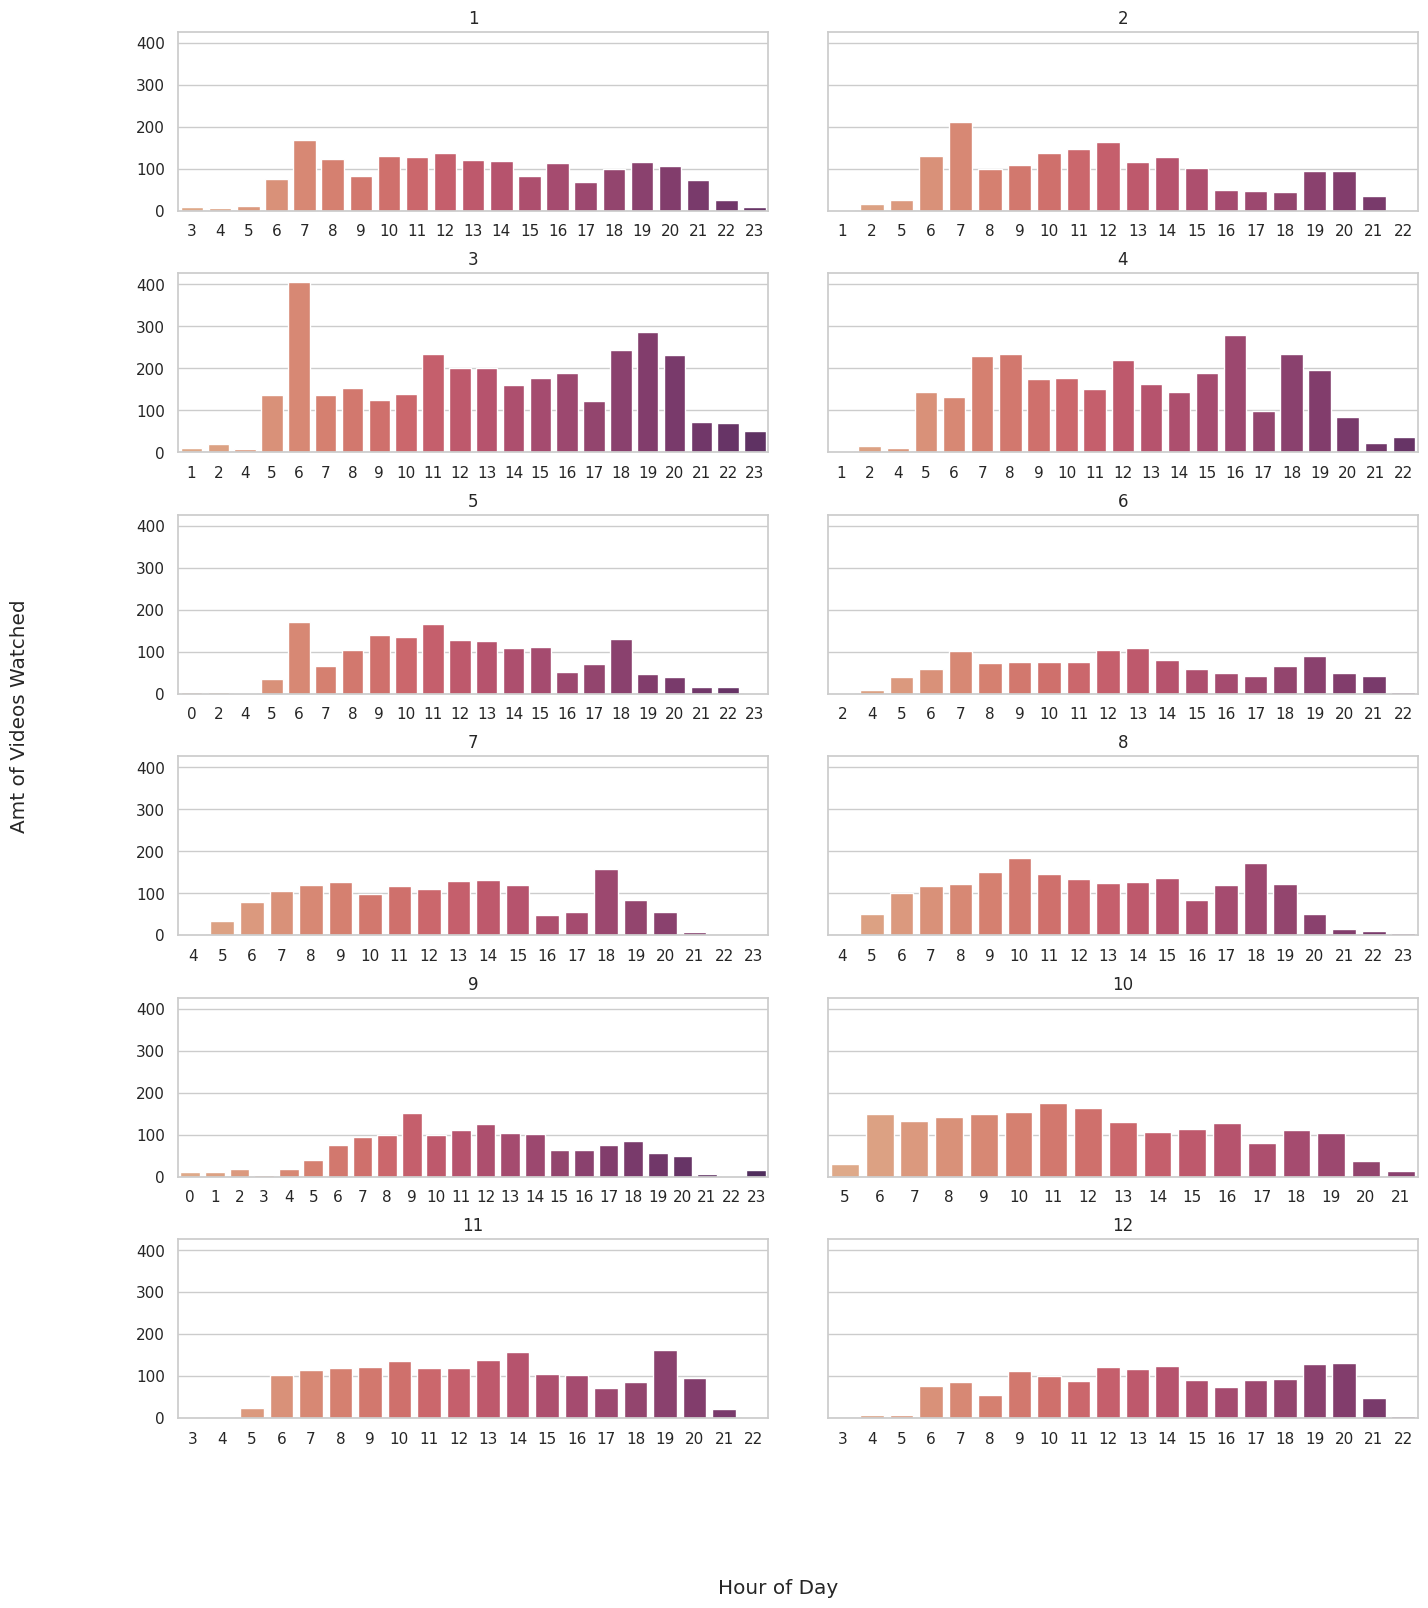

In [17]:
m_h_breakdown = df.groupby(['Month', 'Hour_of_day'])['Month'].value_counts().reset_index()

custom_palette = sns.color_palette("flare", as_cmap=True)

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(16,18), sharey=True)

fig.supxlabel('Hour of Day')
fig.supylabel('Amt of Videos Watched')

# Flatten the 2D array of subplots
axes = axes.flatten()

# Loop through each month and create a subplot
for i, (month, data) in enumerate(m_h_breakdown.groupby('Month')):
    ax = axes[i]
    sns.barplot(x='Hour_of_day', y='count', data=data, ax=ax, palette=color)
    ax.set_title(month)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Adjust layout
plt.subplots_adjust(wspace=0.1, hspace=0.35)

# Show the plot
plt.show()

---

## Question: Which hours are the peak for me for each year?

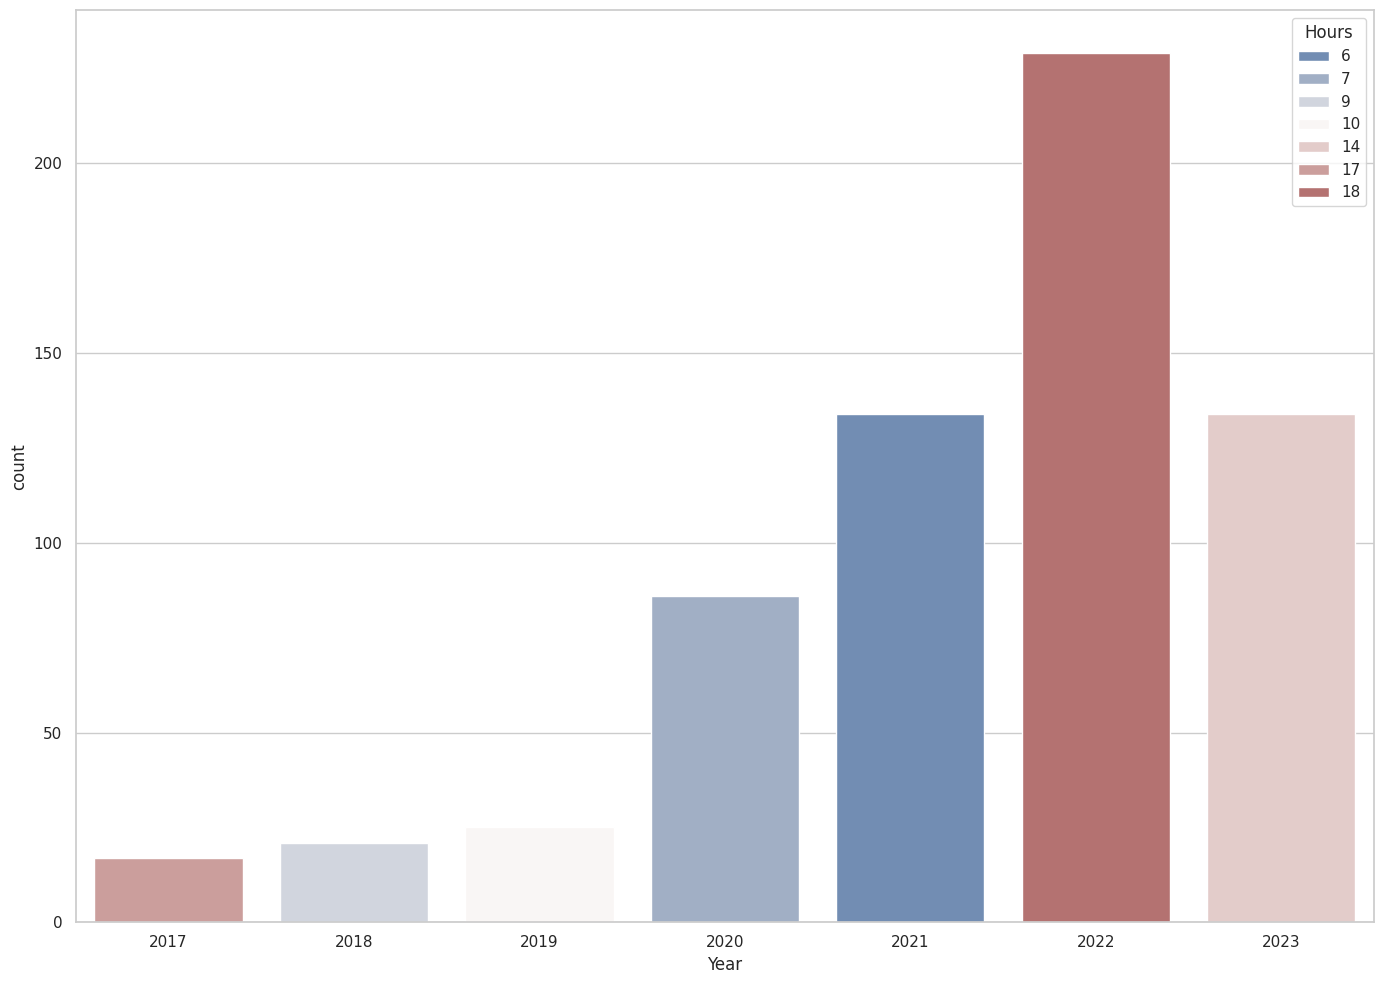

In [18]:
y_h_breakdown = df.groupby(['Year', 'Dow', 'Hour_of_day'])['Hour_of_day'].value_counts().reset_index()
peak_hour_by_year = y_h_breakdown.loc[y_h_breakdown.groupby('Year')['count'].idxmax()]

plt.figure(figsize=(14,10))

sns.barplot(x='Year', y='count', hue='Hour_of_day', data=peak_hour_by_year, palette='vlag', dodge=False)
plt.legend(title='Hours')
plt.tight_layout()

---

## Question: What's the activity by DOW look like?

In [19]:
dow_activity = df.groupby(['Dow']).size().reset_index(name='count')
dow_activity

,Dow,count
0,0,3336
1,1,3200
2,2,3363
3,3,3401
4,4,3788
5,5,2941
6,6,3029


Text(0, 0.5, 'Amt of Videos Watched')

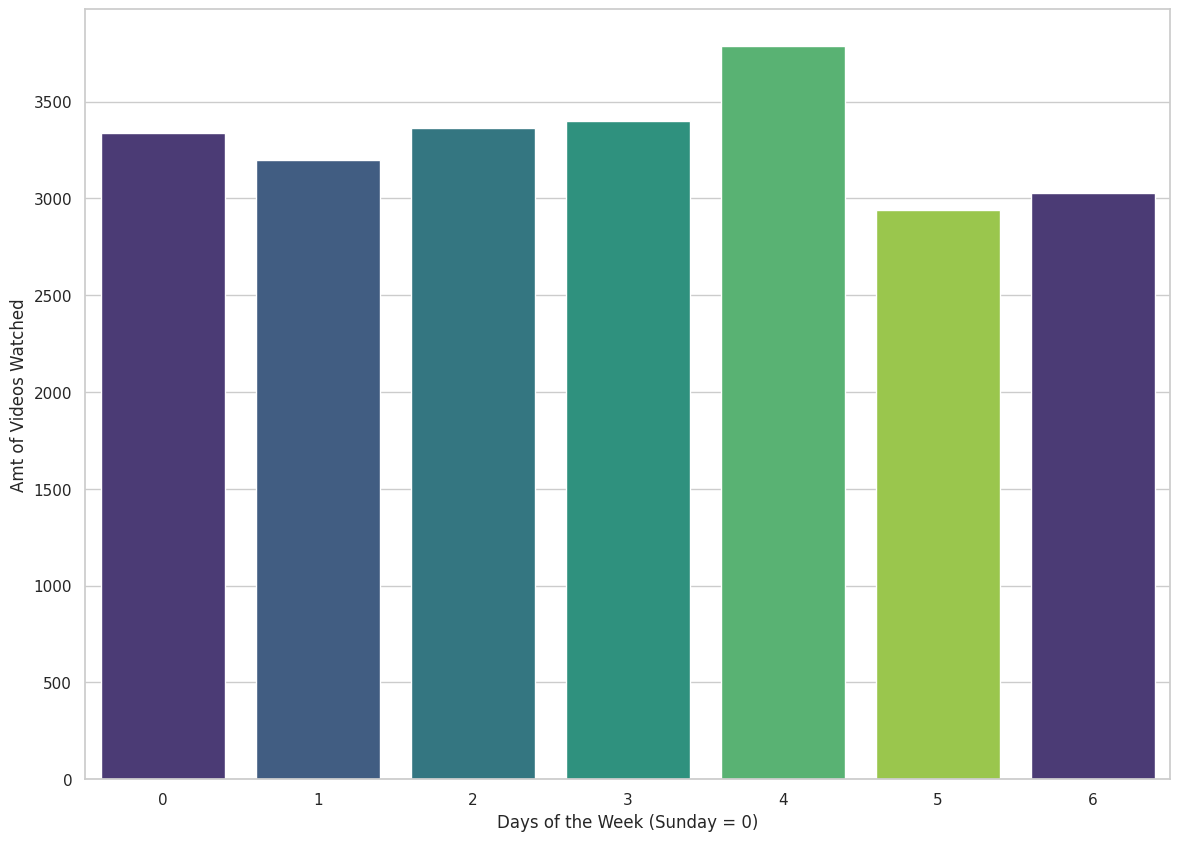

In [20]:
color = sns.color_palette('viridis')


plt.figure(figsize=(14,10))
sns.barplot(x='Dow', y='count', data=dow_activity, palette=color)
plt.xlabel('Days of the Week (Sunday = 0)')
plt.ylabel('Amt of Videos Watched')

## Question: What about DOW for each year?

In [21]:
dow_year_activity = grouped_year_month = df.groupby(['Dow', 'Year'])['Dow'].value_counts().reset_index()

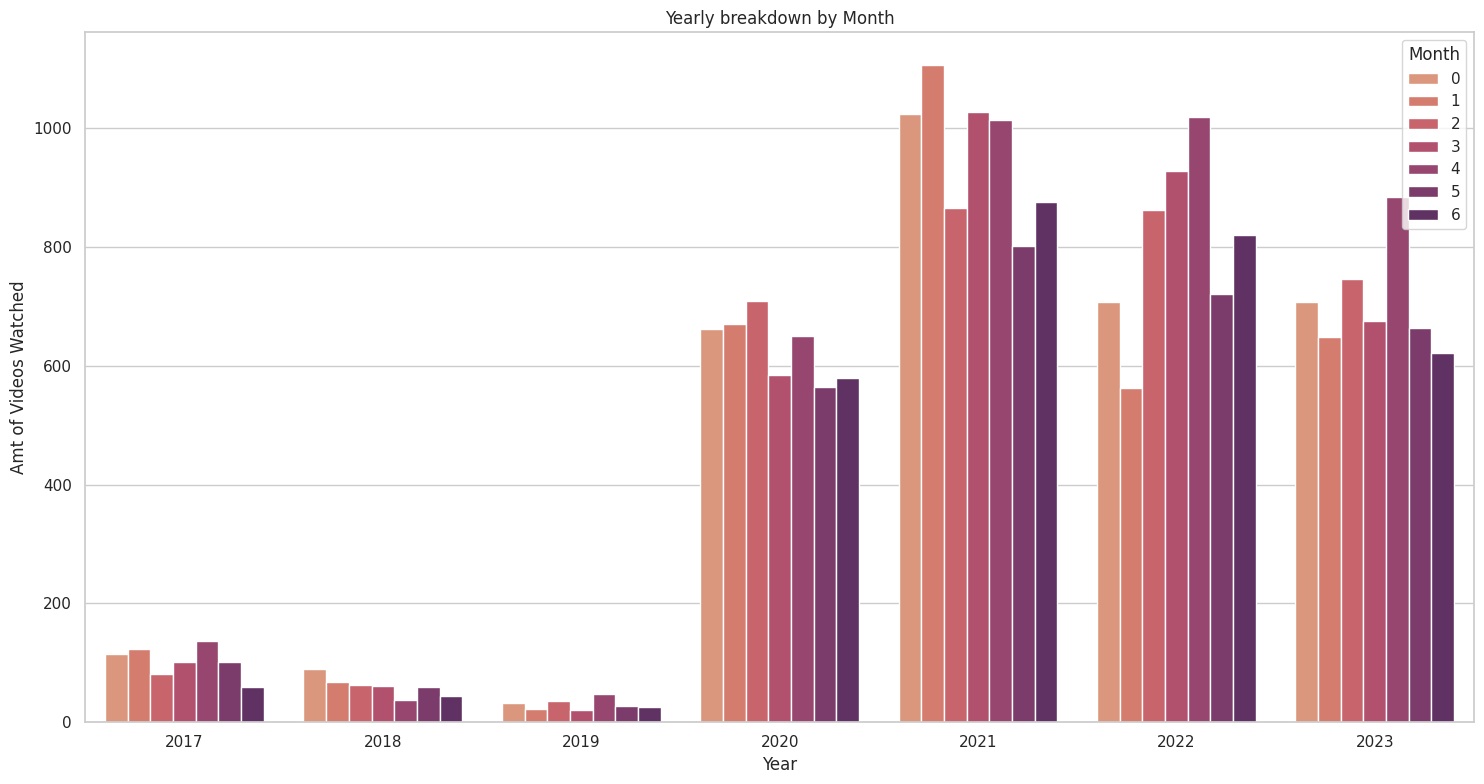

In [22]:
fig, ax = plt.subplots(figsize=(15, 8))

custom_palette = sns.color_palette("flare", n_colors=len(dow_year_activity['Dow'].unique()))

# Use seaborn's barplot to create a grouped bar chart
sns.barplot(x='Year', y='count', hue='Dow', data=dow_year_activity, ax=ax, palette=custom_palette)

# Customize plot
ax.set_xlabel('Year')
ax.set_ylabel('Amt of Videos Watched')
ax.set_title('Yearly breakdown by Month')

ax.legend(title='Month', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

---

## Question: How many videos do I watch a day and per hour on average?

In [23]:
yearly_videos = df.groupby('Year').size().reset_index(name='count')
yearly_videos['daily'] = yearly_videos['count'] / 365
yearly_videos['hourly'] = yearly_videos['daily'] / 24
yearly_videos

,Year,count,daily,hourly
0,2017,720,1.972603,0.082192
1,2018,422,1.156164,0.048174
2,2019,214,0.586301,0.024429
3,2020,4422,12.115068,0.504795
4,2021,6714,18.394521,0.766438
5,2022,5621,15.400000,0.641667
6,2023,4945,13.547945,0.564498


---

## Question: How many videos have I watched that are about Python?
- This is only videos that have Python in the Title so there may be some missing videos.

In [24]:
python_videos = df[df['Video Title'].str.contains('Python')]
python_videos.shape[0]

502

In [25]:
# Top channels for Python content?
python_videos.groupby('Channel Name').size().reset_index(name='count').sort_values(by='count').tail()

,Channel Name,count
38,Corey Schafer,21
134,Tech With Tim,31
61,Indently,38
8,ArjanCodes,38
101,Patrick Loeber,39


<Axes: xlabel='Year', ylabel='count'>

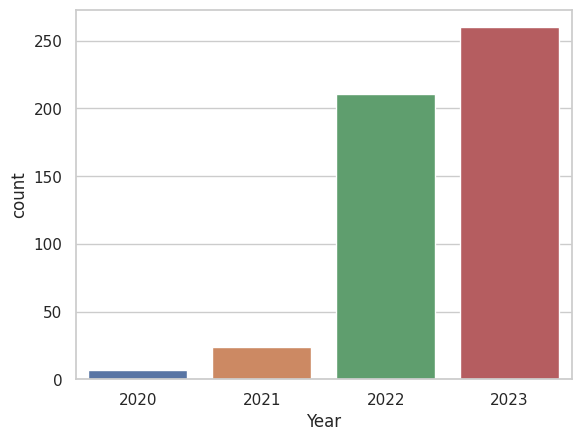

In [26]:
python_years = python_videos.groupby('Year').size().reset_index(name='count')

sns.barplot(x='Year', y='count', data= python_years)

---

## Question: What's the most frequent terms in video titles
- Let's see if we can create our own 'tags' from the video titles

In [27]:
# Split the title into a list for each row
df['Video Title Tags'] = df['Video Title'].apply(lambda x: x.split())  

# Flatten the lists in the column
flat_list = [item for sublist in df['Video Title Tags'] for item in sublist]

In [28]:
# Create the DataFrame object with these tags and counts of each
word_counts = pd.DataFrame({'tags':flat_list}).value_counts().reset_index()

In [29]:
# I don't want words less than 4 characters because they're often filler words (e.g. with, for, the)
title_tags = word_counts[word_counts['tags'].str.len() > 4].sort_values(by='count')
title_tags.tail(10)

,tags,count
62,Review,283
58,Build,297
53,Guide,312
48,Trailer,346
45,Elden,385
40,Diablo,428
34,Gameplay,484
32,Python,497
29,Highlights,542
18,#shorts,788


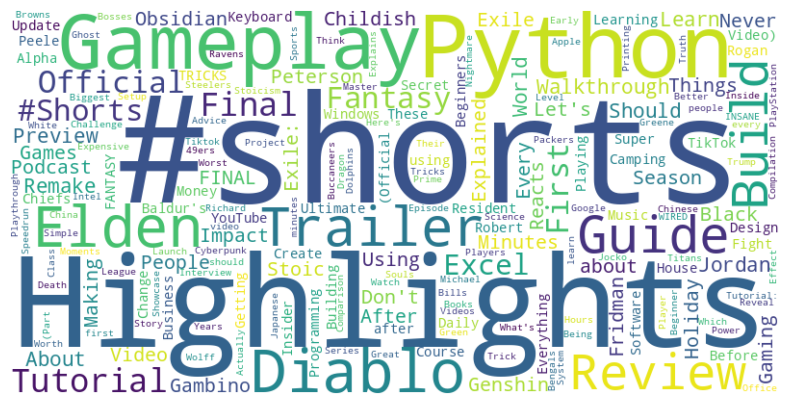

In [30]:
# Let's try something fun:
from wordcloud import WordCloud

# Generate a WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(title_tags.set_index('tags')['count'])

# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Conclusions:
- I watch too much YouTube, it's kind of gross to me now. I wish I had duration data to really fine-tune this analysis.
- I've watched a lot more #shorts than I expected; often I end up watching Python related shorts and sometimes gaming shorts but I will work to avoid these dopamine drip videos.
- It's clear my hobbies are Python and gaming.